José Javier Hurtarte #19707
Pablo Alejandro Méndez #19195

# Laboratorio 7 - Ataques a modelos
## Ataque de extracción

In [79]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
import os
import pandas as pd
from keras.utils import image_dataset_from_directory
from keras import models
from keras import layers
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [67]:
tf.compat.v1.disable_eager_execution()

In [68]:
vulnerable_model = tf.keras.models.load_model("original_cnn.h5")

In [69]:
data_location = "../malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = '../model_copysotherselected'

data = []
for family in os.scandir(data_location):
    if family.is_dir:
        for malware in os.scandir(family):
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family"])
df

,name,path,family
0,000bde2e9a94ba41c0c111ffd80647c2.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
1,000e30a0819ac7ed931d629ce2ef8948.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
2,002f06eff1d222560939be72583d6ae9.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
3,0044f0746b812f6b454ce210bc58c572.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
4,0046a83d932a3d431eb21a99b46d6af7.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
...,...,...,...
9334,08a76fe7517aca8a28ece24684855d1d.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9335,08a9e75728b42c9b54a51f6619d8a174.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9336,08acb94708c0dbb3ba53f6766d681453.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9337,08b0bf03f988fd2e1864e34b58713514.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A


In [70]:

df = df.groupby('family', as_index=False, group_keys=False) \
    .apply(lambda s: s.sample(min(70, len(s)), random_state=987654))

In [71]:

for _, row in df.iterrows():
    os.makedirs(os.path.join(selected_images_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(selected_images_location, row['family'], row['name']))

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'c:\\Users\\jjhh1\\OneDrive\\Escritorio\\JJHH\\SDS\\malimg_dataset\\malimg_paper_dataset_imgs\\Adialer.C\\0665bf2861c065285bf2c37c059f39ca.png' -> '../model_copysotherselected\\Adialer.C\\0665bf2861c065285bf2c37c059f39ca.png'

In [72]:

test_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 1750 files belonging to 25 classes.
Using 350 files for validation.
Found 1750 files belonging to 25 classes.
Using 1400 files for training.


In [73]:

clasificador = KerasClassifier(
    model=vulnerable_model
)


from art.attacks.extraction import CopycatCNN
# Creating the "neural net thief" object
# that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [74]:
blank_model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),     # normalize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data.class_names), activation='softmax')
])

blank_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [75]:

model_stolen = KerasClassifier(
    model=blank_model
)

In [76]:
training_labels = []
training_images = []
for label, image in tfds.as_numpy(training_data):
    training_labels.extend(label)
    training_images.extend(label)

In [78]:

stolen_classifier = copycat_cnn.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1400 samples
Epoch 1/20
1400/1400 [==============================] - 28s 20ms/sample - loss: 3.3016 - accuracy: 0.1143
Epoch 2/20
1400/1400 [==============================] - 24s 17ms/sample - loss: 2.1063 - accuracy: 0.4550
Epoch 3/20
1400/1400 [==============================] - 23s 17ms/sample - loss: 0.9585 - accuracy: 0.7679
Epoch 4/20
1400/1400 [==============================] - 24s 17ms/sample - loss: 0.5397 - accuracy: 0.8579
Epoch 5/20
1400/1400 [==============================] - 25s 18ms/sample - loss: 0.4298 - accuracy: 0.8629
Epoch 6/20
1400/1400 [==============================] - 23s 16ms/sample - loss: 0.2892 - accuracy: 0.9100
Epoch 7/20
1400/1400 [==============================] - 23s 16ms/sample - loss: 0.1971 - accuracy: 0.9243
Epoch 8/20
1400/1400 [==============================] - 23s 16ms/sample - loss: 0.1657 - accuracy: 0.9257
Epoch 9/20
1400/1400 [==============================] - 24s 17ms/sample - loss: 0.1643 - accuracy: 0.9507
Epoch 10/20
1400/1400 [=

In [83]:
probabilities = []
true_labels = []

test_images, test_labels = zip(*tfds.as_numpy(test_data))
for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = clasificador.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch)

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

predicted_labels = np.argmax(probabilities, axis=-1)




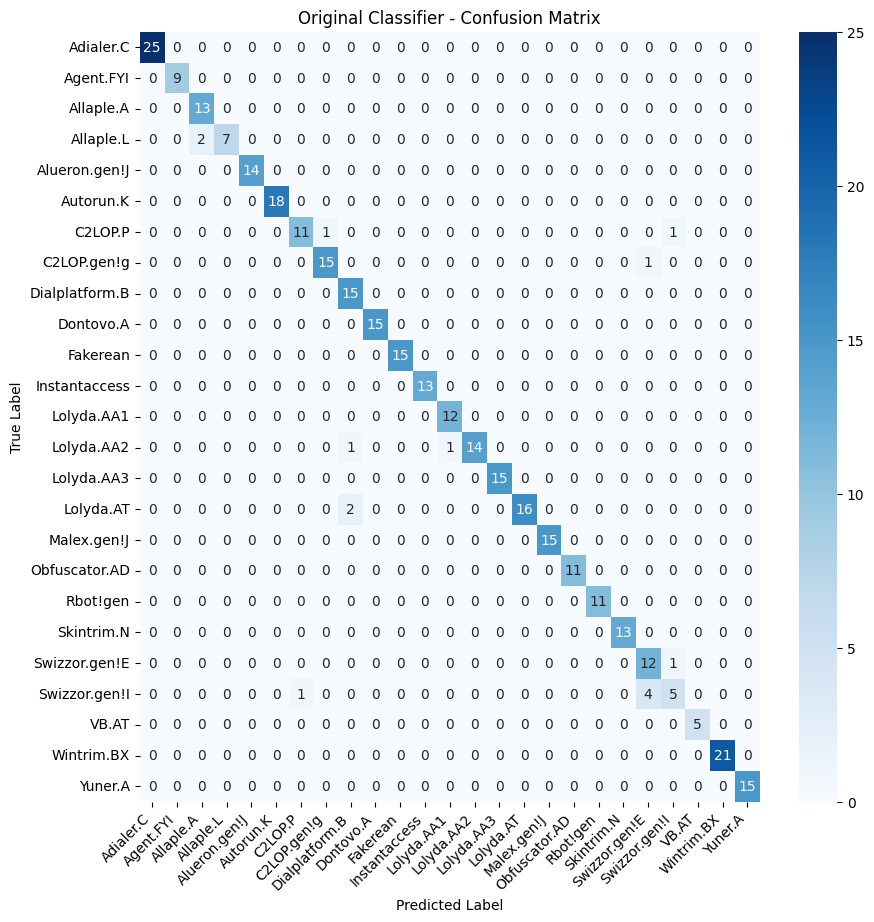

In [88]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier - Confusion Matrix')
plt.show()

In [89]:

probabilities = []
true_labels = []

for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch)

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

predicted_labels = np.argmax(probabilities, axis=-1)



c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


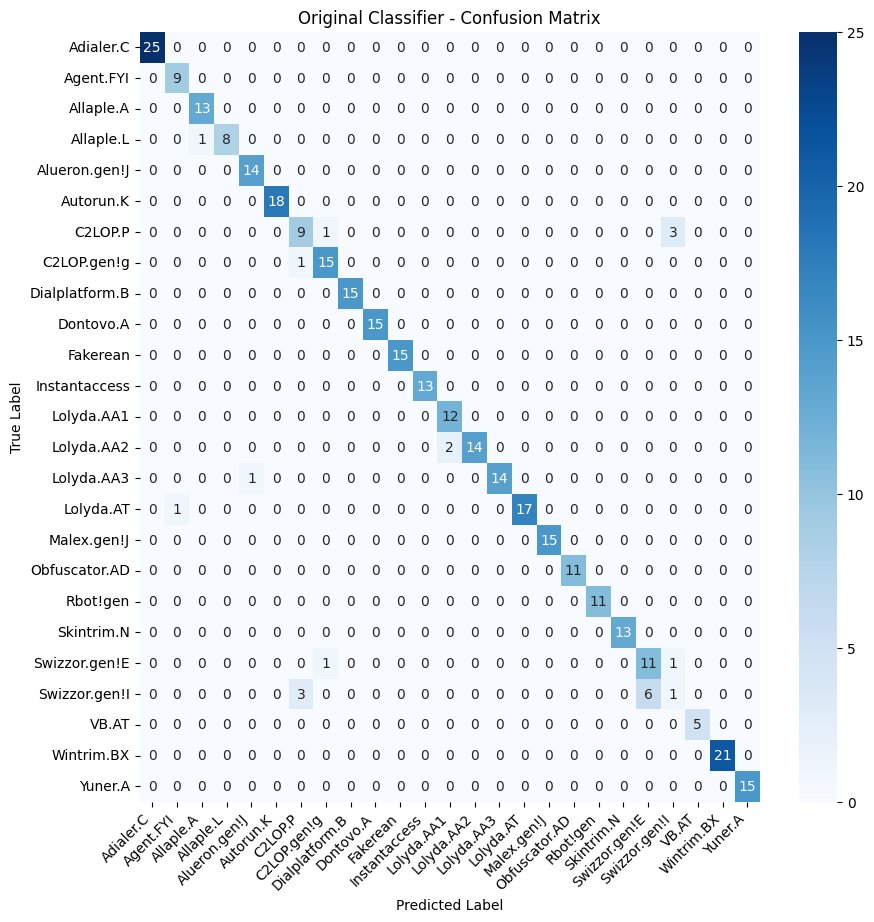

In [90]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stolen Classifier - Confusion Matrix')
plt.show()

In [91]:
#save 
stolen_classifier.save("stolen_cnn.h5")

## Ataque de envenenanmiento